In [1]:
import numpy as np
import pandas as pd 
import lifelines as ll
import matplotlib.pyplot as plt
import plotly as py
import plotly.tools as tls   
from time import time
from scipy.stats import fisher_exact, spearmanr

# First of all we define some functions for our purpose: 

## GI Scores
Load data from [Mapping the Genetic Landscape of Human Cells](https://www.sciencedirect.com/science/article/pii/S0092867418307359?via%3Dihub#mmc2) paper. 
> [**Table S5.**](https://www.sciencedirect.com/science/article/pii/S0092867418307359?via%3Dihub#mmc5)

In [3]:
def get_SLdataset(SL_thr = 1):
    # read data from file 
    myfile = ("CRISPRi_Mapping_paper/Table_S5.xlsx") 
    xl = pd.ExcelFile(myfile)
    sheets = {sheet: xl.parse(sheet) for sheet in xl.sheet_names}
    # print ('Sheets:')
    # print (xl.sheet_names)
    # Read data from *gene GI scores sheet*:
    GIsheet = sheets['gene GI scores and correlations']
    raw_data = pd.DataFrame(data = {
        'Gene1': np.array(GIsheet['Unnamed: 0'][3:]),
        'Gene2': np.array(GIsheet['Unnamed: 1'][3:]), 
        'K562': np.array(GIsheet['K562.4'][3:]),                # g1 <-> g2 GI scores
        'Jurkat': np.array(GIsheet['Jurkat.4'][3:])             # g1 <-> g2 GI scores
    })
    raw_K562   = raw_data.drop(columns='Jurkat').dropna()
    raw_Jurkat = raw_data.drop(columns='K562').dropna()
    K562   = raw_K562[(raw_K562['K562'] > SL_thr) & 
                      (raw_K562['Gene1'] != raw_K562['Gene2'])].reset_index(drop=True)
    Jurkat = raw_Jurkat[(raw_Jurkat['Jurkat'] > SL_thr) &
                        (raw_Jurkat['Gene1'] != raw_Jurkat['Gene2'])].reset_index(drop=True)
    print (f'K562: {round(100* len(K562) / len(raw_K562), 2)}%', end = '\t') 
    print (f'{len(K562)} SLs from {len(raw_K562)} unique gene pairs')
    print (f'Jurkat: {round(100* len(Jurkat) / len(raw_Jurkat), 2)}%', end = '\t') 
    print (f'{len(Jurkat)} SLs from {len(raw_Jurkat)} unique gene pairs ')
    return {'K562':K562, 'Jurkat':Jurkat}

## Read expression data


In [4]:
# make final data set 
def make_study_dataset(filepath, get_RNASeq = False):
    t0 = time()
    with open(filepath) as fp:
        lines = [l.split('\t') for l in fp.readlines()]
        # switch NAs -> 0s
        for i,l in enumerate(lines):
            if 'NA' in l:
                n = len(l[2:])
                l = l[0:2]
                for z in [0]*n:
                    l.append(z)
            lines[i] = l
        genes = [d[0] for d in lines[1:]]
        RNA_seq = [np.array(d[2:], dtype = float) for d in lines[1:]]
                     
        Q1 = [np.quantile(p, 0.1) for p in RNA_seq]       # Low expression threshold
        Q3 = [np.quantile(p, 0.9) for p in RNA_seq]       # High expression threshold        
        
    data = pd.DataFrame(data = [i + j for i,j in zip([-1*(p <= q1) for p,q1 in zip(RNA_seq, Q1)], 
                                                     [ 1*(p >= q3) for p,q3 in zip(RNA_seq, Q3)])],
                        index = [d[0] for d in lines[1:]], columns= lines[0][2:])
        

    print("done in %fs" % (time() - t0))       
    if get_RNASeq == False:
        return data
    else:
        RNA_seq = pd.DataFrame(data = RNA_seq, index = [d[0] for d in lines[1:]],
                               columns= lines[0][2:])
        return RNA_seq, data

## Statistical Test 

In [462]:
oddsratio, pvalue = stats.fisher_exact([[8, 2], [1, 5]])

(0.0, 0.03496503496503495)

In [68]:
def SL_stat_test(filename, cell_line = 'K562'):
    t0 = time()
    SLdata = get_SLdataset()
    RNASeq, data = make_study_dataset(filename, get_RNASeq = True)
    tmp = SLdata[cell_line]
    # filter out missing gene names between GI and expression studies 
    tmp = tmp[pd.DataFrame(tmp.Gene1.tolist()).isin(data.index.tolist()).any(1)].reset_index(drop=True)
    tmp = tmp[pd.DataFrame(tmp.Gene2.tolist()).isin(data.index.tolist()).any(1)].reset_index(drop=True)
    G1 = tmp.Gene1; G2 = tmp.Gene2;
    data_G1 = np.array(data.loc[G1], dtype = int)
    data_G2 = np.array(data.loc[G2], dtype = int)
    Cors = [spearmanr(g1,g2)[0] for g1,g2 in zip(np.array(RNASeq.loc[G1]), np.array(RNASeq.loc[G2]))]    
    test_res = pd.DataFrame(data= np.stack((
        G1 ,G2, tmp[cell_line], Cors,
        np.sum( (data_G1 < 0) * (data_G2 < 0), axis = 1),              # low_low
        np.sum( (data_G1 > 0) * (data_G2 < 0), axis = 1),              # high_low
        np.sum( (data_G1 < 0) * (data_G2 > 0), axis = 1),              # low_high
        np.sum( (data_G1 > 0) * (data_G2 > 0), axis = 1)),             # high_high
        axis = 1), columns=[
        'Gene1', 'Gene2', 'GI_Score', 'Correlation',
        'Obs_Low_Low', 'Obs_High_Low', 'Obs_Low_High', 'Obs_High_High'
#         , 'ChiPval', 'Chi2'
    ])
    
    # random gene pairs 
    r1, r2 = np.random.randint(0, high=len(data) - 1, size=(2,len(tmp)), dtype='int')
    rG1 = [data.index.tolist()[i] for i in r1]
    rG2 = [data.index.tolist()[i] for i in r2]
    data_rG1 = np.array(data.loc[rG1], dtype = int)
    data_rG2 = np.array(data.loc[rG2], dtype = int)
    rCors = [spearmanr(g1,g2)[0] for g1,g2 in zip(np.array(RNASeq.loc[rG1]), np.array(RNASeq.loc[rG2]))]    
    random_test_res = pd.DataFrame(data= np.stack((
        rG1 ,rG2, rCors,
        np.sum( (data_rG1 < 0) * (data_rG2 < 0), axis = 1),              # low_low
        np.sum( (data_rG1 > 0) * (data_rG2 < 0), axis = 1),              # high_low
        np.sum( (data_rG1 < 0) * (data_rG2 > 0), axis = 1),              # low_high
        np.sum( (data_rG1 > 0) * (data_rG2 > 0), axis = 1)),             # high_high
        axis = 1), columns=[
        'Gene1', 'Gene2', 'Correlation',
        'Obs_Low_Low', 'Obs_High_Low', 'Obs_Low_High', 'Obs_High_High'
#         , 'ChiPval', 'Chi2'
    ])
    print("done in %fs" % (time() - t0))
    return test_res, random_test_res

In [69]:
def stat_test_plot(test_res, random_test_res, x_max = 100, y_max = 4000):
    plt.figure(figsize=(10,5))
    for i, Obs in enumerate(['Obs_Low_Low', 'Obs_High_Low', 'Obs_Low_High', 'Obs_High_High']):
        plt.subplot(221 + i)
        plt.hist([
            np.array(test_res[Obs], dtype = int), 
            np.array(random_test_res[Obs], dtype = int),],
            label=['SL','Random'], histtype=u'step',  density = True)
        plt.legend(loc='upper right')
        plt.xlabel(Obs)
        plt.ylabel('Frequency')
        plt.xlim(-1, x_max)
        plt.ylim(0, y_max)

    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

    plt.show()

## Survival analysis 
Read combined study clinical data (downloaded from cBioPortal):

In [26]:
def SL_survival(data, test):
    t0 = time()
    clinical_data = pd.read_csv('cBioPortal/combined_study_clinical_data.csv')
    dfs = []
    for t in test:
        survival_data = []
        g1, g2 = t.split('_') 
        g1_index = [ i for i, g in enumerate(data['raw']['Genes']) if g == g1][0]
        g2_index = [ i for i, g in enumerate(data['raw']['Genes']) if g == g2][0]
        Q1g1 = np.quantile(data['raw']['RNA-Seq'][g1_index], 0.25) # Gene 1 threshold
        Q1g2 = np.quantile(data['raw']['RNA-Seq'][g2_index], 0.25) # Gene 2 threshold
        for p, sam in enumerate(data['raw']['sample_ids']):
            dat1 = 1*(data['raw']['RNA-Seq'][data['raw']['Genes'] == g1][p] <= Q1g1)    
            dat2 = 1*(data['raw']['RNA-Seq'][data['raw']['Genes'] == g2][p] <= Q1g2)
            surS = clinical_data['Overall Survival Status'][clinical_data['Sample ID'] == sam]
            surM = clinical_data['Overall Survival (Months)'][clinical_data['Sample ID'] == sam]
            if len(surS) > 0:
                survival_data.append([sam,dat1,dat2,surS.values[0],surM.values[0]])
        dfs.append(
            pd.DataFrame(survival_data, columns=['sample_ids', g1 + ' is low', g2 + ' is low', 
                                                 'Status', 'Months']).dropna()
        )
    print("done in %fs" % (time() - t0))
    return dfs

# Investigate expression patterns 

## 1st
- ### [Acute Myeloid Leukemia (OHSU, Nature 2018)](https://www.cbioportal.org/study?id=aml_ohsu_2018)

In [7]:
# ls cBioPortal/aml_ohsu_2018

In [8]:
# print meta data
with open('cBioPortal/aml_ohsu_2018/meta_study.txt') as fp:
    print( fp.read() )

type_of_cancer: aml
cancer_study_identifier: aml_ohsu_2018
name: Acute Myeloid Leukemia (OHSU, Nature 2018)
description: Whole-exome sequencing of 672 acute myeloid leukemia samples (with 454 matched normals) from the Beat AML program.
citation: Tyner et al. Nature 2018
pmid: 30333627
short_name: AML (OHSU)
groups: PUBLIC


### Chi-square Test

Low-Low gene pairs for **K562** GI pairs:

In [70]:
test_res, random_test_res = SL_stat_test(
    'cBioPortal/aml_ohsu_2018/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'K562')

K562: 18.08%	18188 SLs from 100576 unique gene pairs
Jurkat: 13.19%	9954 SLs from 75466 unique gene pairs 
done in 10.600467s
done in 116.217217s


> Low Low $Obs/Exp <  $ High High $Obs/Exp$

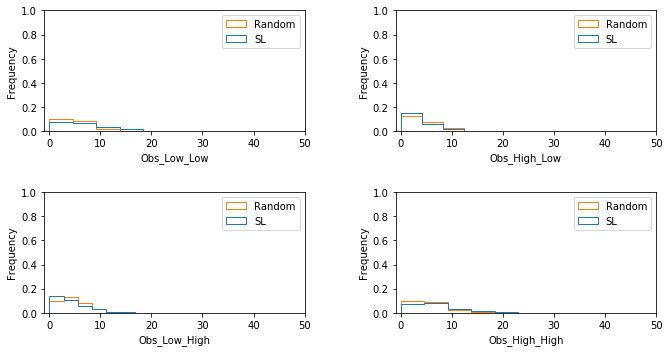

In [71]:
stat_test_plot(test_res, random_test_res, x_max = 50, y_max = 1)

In [72]:
test_res[
    (test_res.Obs_Low_Low < test_res.Obs_High_High) &
    (test_res.Obs_Low_Low < test_res.Obs_Low_High) &
    (test_res.Obs_Low_Low < test_res.Obs_High_Low)
].sort_values('Obs_Low_Low', ascending = False)

,Gene1,Gene2,GI_Score,Correlation,Obs_Low_Low,Obs_High_Low,Obs_Low_High,Obs_High_High
16037,PSMC2,ZMAT5,1.10152,-0.123805,6,9,9,8
4185,CENPK,MED1,2.60943,0.13405,6,7,11,10
8530,FAM98B,PTCD1,1.35385,-0.0283443,5,6,6,7
8140,EXOSC4,NUTF2,2.17923,0.0905905,5,7,6,7
2191,BTF3,TBCB,1.39376,0.127062,5,6,7,10
...,...,...,...,...,...,...,...,...
4638,CKAP5,EIF4A1,1.64594,-0.370615,0,15,6,1
4628,CIT,ZNF511,1.85633,-0.0632986,0,5,3,5
13393,MTERFD1,RBM22,2.74122,-0.365213,0,13,11,4
13408,MTERFD1,ZNF574,1.4608,-0.244032,0,7,9,8


In [73]:
random_test_res.sort_values('Obs_Low_Low', ascending = True)

,Gene1,Gene2,Correlation,Obs_Low_Low,Obs_High_Low,Obs_Low_High,Obs_High_High
6992,PAM,RP11-274K13.5,-0.003848785855194601,0,4,1,11
14875,PTH2R,AL603926.1,-0.061250958991204196,0,7,4,6
5130,ILF3,SLC25A53,-0.19837897915305253,0,9,12,4
14861,PPFIBP1,FRS2,-0.1398318497337285,0,6,7,3
8792,IMP3,BTBD19,-0.4816898149155016,0,13,14,0
...,...,...,...,...,...,...,...
13925,PNKD,MTG2,0.08214395796681896,9,2,7,2
1492,HNRNPA1P30,CTDNEP1,0.3995957894312986,9,4,1,12
9450,CTR9,RP11-229P13.19,0.0026757691458659185,9,4,5,3
13896,ZNF576,FAM131A,0.15457634807855083,9,7,2,9


Low-Low gene pairs for **Jurkat** GI pairs:

In [74]:
test_res, random_test_res = SL_stat_test(
    'cBioPortal/aml_ohsu_2018/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'Jurkat')

K562: 18.08%	18188 SLs from 100576 unique gene pairs
Jurkat: 13.19%	9954 SLs from 75466 unique gene pairs 
done in 10.788834s
done in 99.444228s


> Low Low $Obs/Exp <  $ High High $Obs/Exp$

In [75]:
test_res[
    (test_res.Obs_Low_Low < test_res.Obs_High_High) &
    (test_res.Obs_Low_Low < test_res.Obs_Low_High) &
    (test_res.Obs_Low_Low < test_res.Obs_High_Low)
].sort_values('Obs_Low_Low', ascending = False)

,Gene1,Gene2,GI_Score,Correlation,Obs_Low_Low,Obs_High_Low,Obs_Low_High,Obs_High_High
7861,NIP7,PPWD1,2.09305,0.0417018,6,9,7,7
764,ATP6V1G1,PSMB7,1.11871,-0.0438128,6,7,11,8
1093,BTF3,TBCB,2.50489,0.127062,5,6,7,10
2307,CMAS,RPS18,1.01809,-0.0722982,5,7,9,6
4161,EMC4,KIAA1731,1.11522,-0.0157421,5,9,11,7
...,...,...,...,...,...,...,...,...
5856,MAX,PSMB6,1.55658,-0.329422,0,9,13,9
5858,MAX,PSMD12,1.11356,-0.0726589,0,5,8,2
1918,CDC40,SRSF7,1.13219,-0.349975,0,13,9,5
1920,CDC40,XPO1,2.3208,-0.497648,0,12,13,5


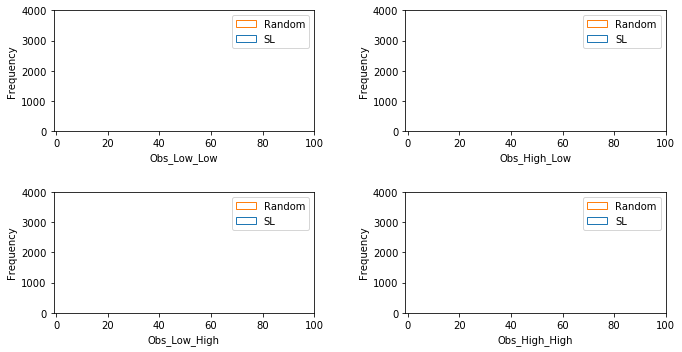

In [76]:
stat_test_plot(test_res, random_test_res)

### Survival analysis 

https://plot.ly/python/v3/ipython-notebooks/survival-analysis-r-vs-python/

# 2nd
- ### [Pediatric Acute Lymphoid Leukemia - Phase II (TARGET, 2018)](https://www.cbioportal.org/study?id=all_phase2_target_2018_pub)

In [43]:
# meta data
filepath = 'cBioPortal/all_phase2_target_2018_pub/meta_study.txt'
with open(filepath) as fp:
    print( fp.read() )

type_of_cancer: bll
cancer_study_identifier: all_phase2_target_2018_pub
name: Pediatric Acute Lymphoid Leukemia - Phase II (TARGET, 2018)
short_name: ALL-Phase II (TARGET, 2018)
description: Comprehensive profiling of ALL Phase 2 samples. <p>TARGET data is intended exclusively for biomedical research using pediatric data (i.e., the research objectives cannot be accomplished using data from adults) that focus on the development of more effective treatments, diagnostic tests, or prognostic markers for childhood cancers. Moreover, TARGET data can be used for research relevant to the biology, causes, treatment and late complications of treatment of pediatric cancers, but is not intended for the sole purposes of methods and/or tool development (please see <a href="https://ocg.cancer.gov/programs/target/using-target-data">Using TARGET Data</a> section of the OCG website). If you are interested in using TARGET data for publication or other research purposes, you must follow the <a href="https

In [44]:
# ls cBioPortal/all_phase2_target_2018_pub

In [45]:
data = make_study_dataset('cBioPortal/all_phase2_target_2018_pub/data_RNA_Seq_mRNA_median_Zscores.txt')

done in 10.104318s


### Chi-square Test

Low-Low gene pairs for **K562** GI pairs:

In [ ]:
test_res, random_test_res = SL_stat_test(
    'cBioPortal/all_phase2_target_2018_pub/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'K562')

In [77]:
with open('cBioPortal/all_phase2_target_2018_pub/data_RNA_Seq_mRNA_median_Zscores.txt') as fp:
    lines = [l.split('\t') for l in fp.readlines()]
    # switch NAs -> 0s
    for i,l in enumerate(lines):
        if 'NA' in l:
            n = len(l[2:])
            l = l[0:2]
            for z in [0]*n:
                l.append(z)
        lines[i] = l
    genes = [d[0] for d in lines[1:]]
    RNA_seq = [np.array(d[2:], dtype = float) for d in lines[1:]]

    Q1 = [np.quantile(p, 0.25) for p in RNA_seq]       # Low expression threshold
    Q3 = [np.quantile(p, 0.75) for p in RNA_seq]       # High expression threshold        

data = pd.DataFrame(data = [i + j for i,j in zip([-1*(p <= q1) for p,q1 in zip(RNA_seq, Q1)], 
                                                 [ 1*(p >= q3) for p,q3 in zip(RNA_seq, Q3)])],
                    index = [d[0] for d in lines[1:]], columns= lines[0][2:])


RNA_seq = pd.DataFrame(data = RNA_seq, index = [d[0] for d in lines[1:]],
                       columns= lines[0][2:])


cell_line = 'Jurkat'
SLdata = get_SLdataset()
tmp = SLdata[cell_line]
# filter out missing gene names between GI and expression studies 
tmp = tmp[pd.DataFrame(tmp.Gene1.tolist()).isin(data.index.tolist()).any(1)].reset_index(drop=True)
tmp = tmp[pd.DataFrame(tmp.Gene2.tolist()).isin(data.index.tolist()).any(1)].reset_index(drop=True)
Cors = []
Obs = []
for g1,g2 in zip(tmp.Gene1,tmp.Gene2):    # g1   g2
    Obs.append([
        [sum(np.array(data.loc[g1] < 0)
         * np.array(data.loc[g2] < 0)),   # low_low
         sum(np.array(data.loc[g1] > 0)
         * np.array(data.loc[g2] < 0))],   # high_low
        [sum(np.array(data.loc[g1] < 0)
         * np.array(data.loc[g2] > 0)),  # low_high
         sum(np.array(data.loc[g1] > 0)
         * np.array(data.loc[g2] > 0))]   # high_high
     ])
    Cors.append (spearmanr(np.array(data.loc[g1]), np.array(data.loc[g2]))[0])
# do chi-square test:
chi2_res = [chi2_contingency(o) for o in np.array(Obs)]
Chi2 = [c[0] for c in chi2_res]
ChiPval = [p[1] for p in chi2_res]
Exp = [np.concatenate((x[3][0], x[3][1])) for x in chi2_res]
Obs = [np.concatenate((o[0], o[1])) for o in Obs]         
# make the test result dataframe:
test_res = pd.DataFrame(data= np.concatenate((
    np.stack(( tmp.Gene1 ,tmp.Gene2, tmp[cell_line]), axis = 1),
    np.array(Obs), np.array(Exp), np.stack(( ChiPval, Chi2, Cors), axis = 1),
    ), axis = 1), columns=[
    'Gene1', 'Gene2', 'GI_Score',
    'Obs_Low_Low', 'Obs_High_Low', 'Obs_Low_High', 'Obs_High_High',
    'Exp_Low_Low' ,'Exp_High_Low', 'Exp_Low_High', 'Exp_High_High', 
    'ChiPval', 'Chi2', 'Correlation'])


K562: 18.08%	18188 SLs from 100576 unique gene pairs
Jurkat: 13.19%	9954 SLs from 75466 unique gene pairs 


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 203 and the array at index 1 has size 7

> Low Low $Obs/Exp <  $ High High $Obs/Exp$

In [ ]:
test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (test.Obs_Low_Low < test.Obs_High_High) &
    (test.Obs_Low_Low < test.Obs_Low_High) &
    (test.Obs_Low_Low < test.Obs_High_Low)
].sort_values('Obs_Low_Low', ascending = False)


In [ ]:
r_test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (r_test.Obs_Low_Low < r_test.Obs_High_High) &
    (r_test.Obs_Low_Low < r_test.Obs_Low_High) &
    (r_test.Obs_Low_Low < r_test.Obs_High_Low)
    & r_test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


In [ ]:
stat_test_plot(test,random_test)

Low-Low gene pairs for **Jurkat** GI pairs:

In [ ]:
test_res, random_test_res = SL_stat_test(
    'cBioPortal/all_phase2_target_2018_pub/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'Jurkat')

> Low Low $Obs/Exp <  $ High High $Obs/Exp$

In [ ]:
test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (test.Obs_Low_Low < test.Obs_High_High) &
    (test.Obs_Low_Low < test.Obs_Low_High) &
    (test.Obs_Low_Low < test.Obs_High_Low)
    & test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


In [ ]:
r_test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (r_test.Obs_Low_Low < r_test.Obs_High_High) &
    (r_test.Obs_Low_Low < r_test.Obs_Low_High) &
    (r_test.Obs_Low_Low < r_test.Obs_High_Low)
    & r_test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


In [ ]:
stat_test_plot(test,r_test)